# Perceptrón

*Aclaración: algunos modelos tuvieron un rendimiento tan bajo, que devuelven siempre $0$. Esto activa una advertencia de sklearn, pero no afecta al resto del notebook*

In [1]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd
import numpy as np
from scoring import *
pd.set_option('display.max_rows', 10)

## Preprocessing Nº1

In [2]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = barrios_a_comunas(df_features)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=0)

pipe = simple_imputer()
pipe = standarizer(pipe)

pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### Sin regularización

In [3]:
parameters = {
    "max_iter": np.arange(1000,5500,500),
    "tol": np.linspace(1e-4,5e-3, 10),
}

grid1 = GridSearchCV(Perceptron(random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid1.fit(X_train, Y_train)
grid1.best_score_

0.7702889094287805

In [4]:
grid_history_table(grid1)

,param_max_iter,param_tol,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,1000,0.0001,0.770289,0.774034,0.497234,0.510099,0.501377
1,4000,0.002278,0.770289,0.774034,0.497234,0.510099,0.501377
2,4000,0.001733,0.770289,0.774034,0.497234,0.510099,0.501377
3,4000,0.001189,0.770289,0.774034,0.497234,0.510099,0.501377
4,4000,0.000644,0.770289,0.774034,0.497234,0.510099,0.501377
...,...,...,...,...,...,...,...
85,2000,0.003367,0.770289,0.774034,0.497234,0.510099,0.501377
86,2000,0.002822,0.770289,0.774034,0.497234,0.510099,0.501377
87,2000,0.002278,0.770289,0.774034,0.497234,0.510099,0.501377
88,2000,0.001189,0.770289,0.774034,0.497234,0.510099,0.501377


In [5]:
metrics_table(Y_test, grid1.best_estimator_.predict(X_test), grid1.best_estimator_.decision_function(X_test))

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.752367,0.761272,0.469041,0.502556,0.485221


Para todos los casos el score es pésimo, ya que es menor que el de un árbol de decisión simple

### Con regularización

Tomando como base el perceptrón anterior, analizamos si aumenta la performance al aplicar regularizaciones

In [6]:
parameters = {
    "penalty": ["l1", "l2", "elasticnet"],
    "alpha": np.linspace(0.00005, 0.001, 30)
}


grid2 = GridSearchCV(Perceptron(max_iter = 1000, tol=0.0001, random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid2.fit(X_train, Y_train)
grid2.best_score_

0.7990032403076112

In [7]:
grid_history_table(grid2)

,param_alpha,param_penalty,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,0.000443,l1,0.799003,0.791067,0.556103,0.502183,0.512904
1,0.000214,l2,0.795119,0.784392,0.521163,0.546906,0.530078
2,0.000902,elasticnet,0.794743,0.798419,0.556935,0.514191,0.530965
3,0.000705,l2,0.793564,0.785084,0.526262,0.543352,0.529859
4,0.000607,l1,0.791009,0.787684,0.541124,0.538449,0.523177
...,...,...,...,...,...,...,...
85,0.000803,elasticnet,0.715569,0.793743,0.556076,0.309328,0.385978
86,0.000738,elasticnet,0.712618,0.775628,0.517389,0.357477,0.394337
87,0.000934,l1,0.711194,0.771584,0.474050,0.424818,0.437549
88,0.00005,l1,0.693079,0.776484,0.476167,0.361628,0.394079


In [8]:
metrics_table(Y_test, grid2.best_estimator_.predict(X_test), grid2.best_estimator_.decision_function(X_test))

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.807054,0.754711,0.467986,0.69909,0.560656


La regularización resultó muy útil, ya que se observa una mejora significativa en los resultados

### Importancia de las features

Analizando los pesos que se le asigna a cada una de las features, podemos comprender un poco mejor el funcionamiento interno del modelo, y ver qué features son más relevantes. Para este análisis, lo más importante es el valor absoluto de los pesos, ya que no es relevante si se trata de un peso positivo o negativo

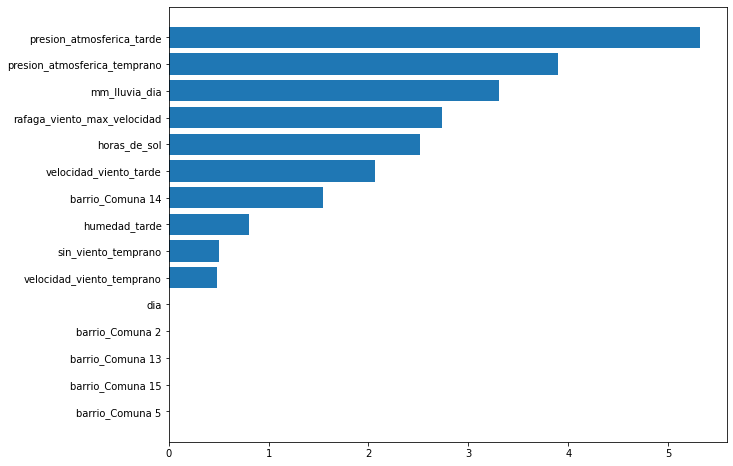

In [9]:
plot_feature_importances(df_features.columns, np.abs(grid2.best_estimator_.coef_[0]), size=15, head=True)

Vemos que el gráfico difiere mucho a lo obtenido en otros modelos, como el árbol de decisión. La feature más importante es la presión atmosférica a la tarde, mientras que en el árbol de decisión era la humedad a la tarde. Esto puede deberse a que, en conjunto (combinación lineal) con otras features, se produce una mayor correlación con la variable target.

Por otro lado, también observamos que solo hay 10 features con pesos no nulos. El resto, no son tenidas en cuenta al momento de tomar una decisión (sea cual sea el valor, se multiplica por 0 y no aporta nada a la fórmula del perceptrón).

De todas formas, el score sigue dando mucho peor que el árbol de decisión.

## Preprocessing Nº2

Probamos eliminar las features que tuvieron poca importancia en el entrenamiento anterior

In [40]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = barrios_a_comunas(df_features)
df_features = drop_poco_importantes(df_features, grid2.best_estimator_.coef_[0], 0)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=0)

pipe = iterative_imputer()
pipe = standarizer(pipe)

pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### Sin regularización

In [12]:
parameters = {
    "max_iter": np.arange(1000,5500,500),
    "tol": np.linspace(1e-4,1e-3,10),
}

grid3 = GridSearchCV(Perceptron(random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid3.fit(X_train, Y_train)
grid3.best_score_

0.7570461797999586

In [13]:
grid_history_table(grid3)

,param_max_iter,param_tol,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,1000,0.0001,0.757046,0.768819,0.521243,0.453046,0.465433
1,4000,0.0005,0.757046,0.768819,0.521243,0.453046,0.465433
2,4000,0.0004,0.757046,0.768819,0.521243,0.453046,0.465433
3,4000,0.0003,0.757046,0.768819,0.521243,0.453046,0.465433
4,4000,0.0002,0.757046,0.768819,0.521243,0.453046,0.465433
...,...,...,...,...,...,...,...
85,2000,0.0007,0.757046,0.768819,0.521243,0.453046,0.465433
86,2000,0.0006,0.757046,0.768819,0.521243,0.453046,0.465433
87,2000,0.0005,0.757046,0.768819,0.521243,0.453046,0.465433
88,2000,0.0003,0.757046,0.768819,0.521243,0.453046,0.465433


In [14]:
metrics_table(Y_test, grid3.best_estimator_.predict(X_test), grid3.best_estimator_.decision_function(X_test))

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.744873,0.773081,0.493343,0.503679,0.498457


Los resultados empeoraron un poco en comparación al primer preprocessing

### Con regularización

In [15]:
parameters = {
    "penalty": ["l1", "l2", "elasticnet"],
    "alpha": np.linspace(0.00005, 0.001, 30)
}


grid4 = GridSearchCV(Perceptron(max_iter = 1000, tol=0.0001, random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid4.fit(X_train, Y_train)
grid4.best_score_

0.8141973287381365

In [16]:
grid_history_table(grid4)

,param_alpha,param_penalty,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,0.000476,elasticnet,0.814197,0.765930,0.515141,0.627495,0.546900
1,0.000181,l1,0.813171,0.784347,0.415689,0.505043,0.455439
2,0.000803,l1,0.812504,0.790331,0.641022,0.415756,0.423943
3,0.000705,l1,0.810568,0.790151,0.557882,0.562193,0.535763
4,0.000574,l1,0.809963,0.742766,0.515234,0.580649,0.459800
...,...,...,...,...,...,...,...
85,0.000574,l2,0.640021,0.742616,0.461466,0.295833,0.316949
86,0.000509,l2,0.630276,0.705991,0.400986,0.342509,0.336170
87,0.000378,l2,0.629148,0.749185,0.427747,0.277636,0.319280
88,0.000771,l2,0.618267,0.745065,0.377888,0.344246,0.343762


In [17]:
metrics_table(Y_test, grid4.best_estimator_.predict(X_test), grid4.best_estimator_.decision_function(X_test))

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.772626,0.803121,0.638897,0.277341,0.386783


Los resultados son interesantes ya que, si bien el score en el test de validación no fue bueno, el score que provee GridSearch es mayor. Esto quizá signifique que el cálculo interno de las probabilidades es distinto en GridSearch.

Podemos intentar solucionar esto utilizando un calibrador

### Calibración

In [18]:
parameters = {
    "base_estimator__penalty": ["l1", "l2", "elasticnet"],
    "base_estimator__alpha": np.linspace(0.00005, 0.001, 30)
}

perc = Perceptron(max_iter = 1000, tol=0.0001, random_state=0)

grid5 = GridSearchCV(CalibratedClassifierCV(perc),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid5.fit(X_train, Y_train)
grid5.best_score_

0.8387816884372136

In [19]:
grid_history_table(grid5)

,param_base_estimator__alpha,param_base_estimator__penalty,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,0.000279,l1,0.838782,0.825959,0.778961,0.312831,0.445209
1,0.000214,l1,0.837539,0.822261,0.799037,0.275770,0.406585
2,0.000771,elasticnet,0.837339,0.821615,0.805821,0.271331,0.402353
3,0.000705,elasticnet,0.836792,0.818247,0.798183,0.251589,0.380177
4,0.000771,l1,0.835836,0.809903,0.802047,0.215795,0.317684
...,...,...,...,...,...,...,...
85,0.000771,l2,0.815750,0.803319,0.752477,0.181892,0.281649
86,0.000378,l2,0.814005,0.798990,0.747340,0.159401,0.247296
87,0.00005,l1,0.813375,0.805815,0.805049,0.178271,0.275833
88,0.000509,l1,0.812632,0.806536,0.749049,0.204186,0.306301


In [20]:
metrics_table(Y_test, grid5.best_estimator_.predict(X_test), grid5.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.826262,0.827801,0.79409,0.311635,0.447609


Los scores son significativamente mejores, aunque sigue habiendo diferencia entre las métricas de GridSearch y la tabla con los datos de validación.

### Cambiando los pesos de las clases

In [21]:
parameters = {
    "base_estimator__penalty": ["l1", "l2", "elasticnet"],
    "base_estimator__alpha": np.linspace(0.00005, 0.001, 30)
}

perc = Perceptron(max_iter = 1000, tol=0.0001, class_weight="balanced", random_state=0)

grid6 = GridSearchCV(CalibratedClassifierCV(perc),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    scoring = SCORINGS,
                    refit=METRIC,
                    n_jobs = -1)

grid6.fit(X_train, Y_train)
grid6.best_score_

0.8390505515481477

In [22]:
grid_history_table(grid6)

,param_base_estimator__alpha,param_base_estimator__penalty,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,0.000247,l1,0.839051,0.817616,0.816616,0.242260,0.367855
1,0.000672,l1,0.838740,0.821344,0.780533,0.283015,0.413355
2,0.000836,l1,0.838276,0.814339,0.810057,0.235341,0.351762
3,0.000214,l1,0.837790,0.814624,0.809449,0.234942,0.352485
4,0.000836,elasticnet,0.837784,0.814203,0.809148,0.231773,0.342584
...,...,...,...,...,...,...,...
85,0.00041,l2,0.816108,0.809408,0.751007,0.222594,0.340865
86,0.001,l2,0.813333,0.801245,0.727228,0.176119,0.281278
87,0.000181,l2,0.811742,0.801756,0.762708,0.171089,0.271707
88,0.000869,l2,0.811695,0.803259,0.759493,0.176054,0.280774


In [23]:
metrics_table(Y_test, grid6.best_estimator_.predict(X_test), grid6.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.832506,0.82043,0.770358,0.281955,0.412817


El score no solo mejoró notablemente, sino que también se aproxima más al valor de GridSearch.

También vemos que el recall es realmente bajo. Para comprender el motivo, graficamos la matriz de confusión del modelo

### Matriz de confusión

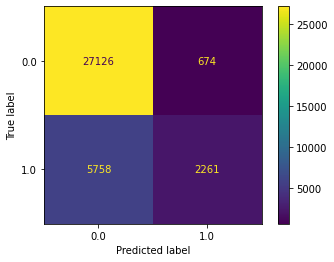

In [24]:
ConfusionMatrixDisplay.from_predictions(Y_test, grid6.best_estimator_.predict(X_test))

Vemos que el principal motivo por el cual el recall es tan bajo, es el alto número de falsos negativos. Como paso con otros modelos, al estar desbalanceadas las clases, el perceptrón tiende a predecir con mayor facilidad la clase 0 (no llovió al día siguiente)

## Modelo final

El mejor modelo resultó ser el último. Este será el que se considere al momento de comparar los distintos modelos

## Predicción de nuevos datos

In [41]:
df_extra = pd.read_csv("datasets/df_extra.csv", low_memory = False, index_col = "id")

common(df_extra)
viento_trigonometrico(df_extra)
df_extra = barrios_a_comunas(df_extra)
df_extra = drop_poco_importantes(df_extra, grid2.best_estimator_.coef_[0], 0)

model = grid6.best_estimator_

pipe.steps.append(("perc", model))

df_extra_predict = pd.DataFrame({"id": df_extra.index, "llovieron_hamburguesas_al_dia_siguiente": pipe.predict(df_extra)})
df_extra_predict.set_index("id", inplace = True)
df_extra_predict.replace({"llovieron_hamburguesas_al_dia_siguiente": {0.0: "no", 1.0: "si"}}, inplace = True)
df_extra_predict.to_csv("predicciones/Perceptron.csv")